# Handling multi-dimensional arrays with xarray

## Authors & Contributors

### Authors

- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)
- Anne Fouilloux, Simula Research Laboratory (Norway), [@annefou](https://github.com/annefou)

### Contributors

- Alejandro Coca-Castro, The Alan Turing Institute (United Kingdom), [@acocac](https://github.com/acocac)
- Guillaume Eynard-Bontemps, CNES (France), [@guillaumeeb](https://github.com/guillaumeeb)

<div class="alert alert-info">
    <i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> <b>Overview</b>
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Xarray?</li>
        <li>How to open a local file?</li>
        <li>How to print metadata information?</li>
        <li>How to make a selection?</li>
        <li>How to visualize with matplotlib?</li>
        <li>How to perform basic computations, statistics and aggregations?</li>
        <li>How to mask data?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Xarray Python ecosystem</li>
        <li>Learn file handling with xarray</li>
        <li>Learn to get metadata information</li>
        <li>Learn to select and mask data</li>
        <li>Learn to make basic computations, aggregations and statistics</li>
        <li>Learnn to visualize data</li>
    </ul>
</div>

## Context

We will be using the [Pangeo](https://pangeo.io/) open-source software stack for visualizing the near-surface temperature and computing time averaged values (such as seasonal mean and other statistics).

### Data

In this episode, we will use [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) data.

This dataset can be discovered through the [CMIP6 online catalog](https://pangeo-data.github.io/pangeo-cmip6-cloud/) or from [ESGF](https://esgf.llnl.gov/).

The same dataset can also be downloaded from [Zenodo](https://zenodo.org/): [Near-surface Temperature from CMIP6 NCAR CESM2 historical monthly dataset for CLIVAR CMIP6 Bootcamp](https://zenodo.org/record/7181714/files/CMIP6_NCAR_CESM2_historical_amon_gn.nc).

## Setup

This episode uses the following main Python packages:

- xarray {cite:ps}`a-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- pooch {cite:ps}`a-pooch-Uieda2020`
- numpy {cite:ps}`a-numpy-harris2020`

Please install these packages if they are not already available in your Python environment (see [Setup page](https://pangeo-data.github.io/foss4g-2022/before/setup.html)).

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend that you install and import all the necessary libraries at the top of your Jupyter notebook.

In [1]:
import xarray as xr

### Fetch Data

- For now we will fetch a netCDF file containing the near-surface temperature from one single CMIP6 model CESM2.
- The file is available in a Zenodo repository. We will download it using using `pooch`, a very handy Python-based library to download and cache your data files locally (see further info [here](https://www.fatiando.org/pooch/latest/index.html))
- In the [Data access and discovery](https://pangeo-data.github.io/clivar-2022/pangeo101/data_discovery.html) episode, we will learn about different ways to access data, including access to remote data.

In [2]:
import pooch

In [3]:
tas_file = pooch.retrieve(
    url="https://zenodo.org/record/7181714/files/CMIP6_NCAR_CESM2_historical_amon_gn.nc",
    known_hash="md5:5f86251e5bc5ef9b86a3a86cd06a536b",
    path=f".",
)

## Open and read metadata through Xarray

In [4]:
tas_ds = xr.open_dataset(tas_file)

As the dataset is in the NetCDF format, Xarray automatically selects the correct engine (this happens in the background because engine='netcdf' has been automatically specified). Other common options are "h5netcdf" or "zarr".
GeoTiff data can also be read, but to access it requires rioxarray, which will be quickly covered later.
Supposing that you have a dataset in an unrecognised format, you can always create your own reader as a subclass of the backend entry point and pass it through the engine parameter.

:::{tip}
If you get an error with the previous command, first check the location of the input file some_hash-CMIP6_NCAR_CESM2_historical_amon_gn.nc: it should have been downloaded in the same directory as your Jupyter Notebook.
:::

In [5]:
tas_ds

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 ...
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object ...
  * member_id  (member_id) object 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:              v20190308
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

## What is xarray?

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multi-dimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.

### How is xarray structured?

Xarray has two core data structures, which build upon and extend the core strengths of NumPy and Pandas libraries. Both data structures are fundamentally N-dimensional:

- [DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray) is the implementation of a labeled, N-dimensional array. It is an N-D generalization of a Pandas.Series. The name DataArray itself is borrowed from [Fernando Perez’s datarray project](http://fperez.org/py4science/datarray/), which prototyped a similar data structure.

- [Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html#xarray.Dataset) is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray as the pandas.DataFrame.


## Accessing Coordinates and Data Variables 

DataArray, within Datasets, can be accessed through:
- the dot notation like Dataset.NameofVariable  
- or using square brackets, like Dataset['NameofVariable'] (NameofVariable needs to be a string so use quotes or double quotes)

In [6]:
tas_ds.time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

`tas_ds.time` is a one-dimensional `xarray.DataArray` with dates of type `cftime.DatetimeNoLeap`

In [7]:
tas_ds.tas

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 192, lon: 288)>
[109486080 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

`tas_ds.tas` is a 4-dimensional `xarray.DataArray` with tas values of type `float32`

In [8]:
tas_ds['tas']

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 192, lon: 288)>
[109486080 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

Same can be achieved for attributes and a DataArray.attrs will return a dictionary.

In [9]:
tas_ds['tas'].attrs

{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'near-surface (usually, 2 meter) air temperature',
 'description': 'near-surface (usually, 2 meter) air temperature',
 'frequency': 'mon',
 'id': 'tas',
 'long_name': 'Near-Surface Air Temperature',
 'mipTable': 'Amon',
 'out_name': 'tas',
 'prov': 'Amon ((isd.003))',
 'realm': 'atmos',
 'standard_name': 'air_temperature',
 'time': 'time',
 'time_label': 'time-mean',
 'time_title': 'Temporal mean',
 'title': 'Near-Surface Air Temperature',
 'type': 'real',
 'units': 'K',
 'variable_id': 'tas'}

### Xarray and Memory usage

Once a Data Array|Set is opened, xarray loads into memory only the coordinates and all the metadata needed to describe it.
The underlying data, the component written into the datastore, are loaded into memory as a NumPy array, only once directly accessed; once in there, it will be kept to avoid re-readings.
This brings the fact that it is good practice to have a look to the size of the data before accessing it. A classical mistake is to try loading arrays bigger than the memory with the obvious result of killing a notebook Kernel or Python process.
If the dataset does not fit in the available memory, then the only option will be to load it through the chunking; later on, in the tutorial 'chunking_introduction', we will introduce this concept.

As the size of the data is not too big here, we can continue without any problem. But let's first have a look to the actual size and then how it impacts the memory once loaded into it.

In [10]:
import numpy as np

In [11]:
print(f'{np.round(tas_ds.tas.nbytes / 1024**2, 2)} MB') # all the data are automatically loaded into memory as NumpyArray once they are accessed.

417.66 MB


In [12]:
tas_ds.tas.data

array([[[[245.32208, 245.32208, 245.32208, ..., 245.32208, 245.32208,
          245.32208],
         [246.10596, 246.06238, 245.9003 , ..., 246.16695, 246.15019,
          246.12573],
         [246.72545, 246.68094, 246.65623, ..., 246.98813, 246.92969,
          246.84184],
         ...,
         [245.5208 , 245.56802, 245.61319, ..., 245.41414, 245.44745,
          245.47954],
         [245.02821, 245.0406 , 245.05339, ..., 244.98322, 244.99951,
          245.01454],
         [244.50035, 244.50319, 244.50577, ..., 244.48999, 244.49379,
          244.49722]],

        [[232.51073, 232.51073, 232.51073, ..., 232.51073, 232.51073,
          232.51073],
         [233.30011, 233.26118, 233.10924, ..., 233.32413, 233.32066,
          233.31026],
         [233.92563, 233.88283, 233.85846, ..., 234.17664, 234.11632,
          234.03847],
         ...,
         [245.86388, 245.92415, 245.97963, ..., 245.71205, 245.76198,
          245.80855],
         [244.68976, 244.70775, 244.72629, ..., 24

## Renaming Coordinates and Data Variables 

It may be useful to rename variables or coordinates to more common ones. It is usually not necessary for CMIP6 data because coordinate and variable names are fully standardized. CMIP6 data follows [CF-conventions](https://cfconventions.org/). 

We will however show you how you can rename coordinates and/or variables and revert back our change.

In [13]:
tas_ds = tas_ds.rename(lon='longitude', lat='latitude')

In [14]:
tas_ds

<xarray.Dataset>
Dimensions:    (latitude: 192, nbnd: 2, longitude: 288, member_id: 1, time: 1980)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds   (latitude, nbnd) float32 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds   (longitude, nbnd) float32 -0.625 0.625 0.625 ... 358.1 359.4
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, latitude, longitude) float32 245.3 ... 245.0
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:              v20190308
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

Now let's revert back our change and rename latitude and longitude to the most common names e.g. 'lat' and 'lon'.

In [15]:
tas_ds = tas_ds.rename(longitude='lon', latitude='lat')

In [16]:
tas_ds

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 245.3 245.3 ... 245.0 245.0
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:              v20190308
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

## Selection methods

As underneath DataArrays are Numpy Array objects (that implement the standard Python x[obj] (x: array, obj: int,slice) syntax). Their data can be accessed through the same approach of numpy indexing.

In [17]:
tas_ds.tas[0,0,100,100]

<xarray.DataArray 'tas' ()>
array(300.38446, dtype=float32)
Coordinates:
    lat        float64 4.241
    lon        float64 125.0
    time       object 1850-01-15 12:00:00
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

or slicing

In [18]:
tas_ds.tas[0, 0:5, 100:110, 100:110]

<xarray.DataArray 'tas' (time: 5, lat: 10, lon: 10)>
array([[[300.38446, 300.08688, ..., 300.71   , 300.7822 ],
        [300.2441 , 299.95798, ..., 300.53357, 300.62396],
        ...,
        [297.77292, 298.71323, ..., 299.71173, 299.8677 ],
        [297.73315, 298.60205, ..., 299.6976 , 299.812  ]],

       [[299.65933, 299.26968, ..., 300.4081 , 300.55255],
        [299.5267 , 299.12592, ..., 300.40277, 300.5284 ],
        ...,
        [297.3739 , 298.0038 , ..., 299.71512, 299.80475],
        [297.3448 , 297.89917, ..., 299.4545 , 299.56235]],

       ...,

       [[300.5706 , 300.41907, ..., 300.87616, 300.82022],
        [300.4315 , 300.26505, ..., 300.84323, 300.8234 ],
        ...,
        [299.8353 , 299.99384, ..., 300.41165, 300.41684],
        [299.85242, 299.9631 , ..., 300.28253, 300.27316]],

       [[300.81683, 300.7148 , ..., 301.1554 , 301.1403 ],
        [300.5332 , 300.56613, ..., 300.99164, 301.0214 ],
        ...,
        [300.82352, 300.53986, ..., 300.4276 , 300.4221 ],
        [300.87964, 300.58102, ..., 300.36655, 300.33893]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 4.241 5.183 6.126 7.068 ... 9.895 10.84 11.78 12.72
  * lon        (lon) float64 125.0 126.2 127.5 128.8 ... 132.5 133.8 135.0 136.2
  * time       (time) object 1850-01-15 12:00:00 ... 1850-05-15 12:00:00
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

As it is not easy to remember the order of dimensions, Xarray really helps by making it possible to select the position using names:

- `.isel` -> selection based on positional index
- `.sel`  -> selection based on coordinate values

We first check the number of elements in each coordinate of the `tas` Data Variable using the built-in method sizes. Same result can be achieved querying each coordinate using the Python built-in function `len`.

In [19]:
tas_ds.tas.sizes

Frozen({'member_id': 1, 'time': 1980, 'lat': 192, 'lon': 288})

In [20]:
tas_ds.tas.isel(member_id=0,time=0, lat=100, lon=100) # same as tas_ds.tas[0,0,100,100]

<xarray.DataArray 'tas' ()>
array(300.38446, dtype=float32)
Coordinates:
    lat        float64 4.241
    lon        float64 125.0
    time       object 1850-01-15 12:00:00
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

The more common way to select a point is through the labeled coordinate using the `.sel` method.

In [21]:
tas_ds.tas.sel(time='2010-01-15')

<xarray.DataArray 'tas' (member_id: 1, time: 1, lat: 192, lon: 288)>
array([[[[245.71487, ..., 245.71481],
         ...,
         [246.21568, ..., 246.21373]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2010-01-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

Time is easy to be used as there is a 1 to 1 correspondence with values in the index, float values are not that easy to be used and a small discrepancy can make a big difference in terms of results.


Coordinates are always affected by precision issues; the best option to quickly get a point over the coordinates is to set the sampling method (method='') that will search for the closest point according to the specified one.

Options for the method are:
- pad / **f**fill: propagate last valid index value forward
- backfill / **b**fill: propagate next valid index value backward
- nearest: use nearest valid index value

Another important parameter that can be set is the tolerance that specifies the distance between the requested and the target (so that abs(index\[indexer] - target) <= tolerance) from [documentation](https://xarray.pydata.org/en/v0.17.0/generated/xarray.DataArray.sel.html#:~:text=xarray.DataArray.sel%20%C2%B6%20DataArray.sel%28indexers%3DNone%2C%20method%3DNone%2C%20tolerance%3DNone%2C%20drop%3DFalse%2C%20%2A%2Aindexers_kwargs%29%20%C2%B6,this%20method%20should%20use%20labels%20instead%20of%20integers.).

In [22]:
tas_ds.sel(lat=46.3, lon=8.8, method='nearest')

<xarray.Dataset>
Dimensions:    (nbnd: 2, member_id: 1, time: 1980)
Coordinates:
    lat        float64 46.65
    lat_bnds   (nbnd) float32 46.18 47.12
    lon        float64 8.75
    lon_bnds   (nbnd) float32 8.125 9.375
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time) float32 272.7 273.8 274.2 ... 278.1 275.4 272.2
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:              v20190308
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

:::{warning}
To select a single real value without specifying a method, you would need to specify the exact encoded value; not the one you see when printed.
:::

In [23]:
tas_ds.isel(lon=100).lon.values.item()

125.0

In [24]:
tas_ds.isel(lat=100).lat.values.item()

4.240837696335078

In [25]:
tas_ds.sel(lat=4.240837696335078, lon=125.0)

<xarray.Dataset>
Dimensions:    (nbnd: 2, member_id: 1, time: 1980)
Coordinates:
    lat        float64 4.241
    lat_bnds   (nbnd) float32 3.77 4.712
    lon        float64 125.0
    lon_bnds   (nbnd) float32 124.4 125.6
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time) float32 300.4 299.7 299.9 ... 302.3 302.0 301.8
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:              v20190308
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

That is why we use a `method`! It makes your life easier to deal with inexact matches.

As the exercise is focused on an Area Of Interest, this can be obtained through a bounding box defined with slices.

In [26]:
tas_AOI = tas_ds.tas.sel(lat=slice(54.5,71.5), lon=slice(-2.5,42.5))
tas_AOI

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 18, lon: 35)>
array([[[[277.14154, ..., 255.24866],
         ...,
         [271.17374, ..., 259.73807]],

        ...,

        [[283.0737 , ..., 269.6892 ],
         ...,
         [272.89108, ..., 271.8542 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

:::{tip} the values for `lat` and `lon` need to be selected in the order shown in the coordinate section (here in increasing order) and not always in increasing order?
**You need to use the same order as the corresponding DataArray**.
:::

## Plotting
   Plotting data can easily be obtained through matplotlib.pyplot back-end [matplotlib documentation](https://matplotlib.org/stable/index.html).

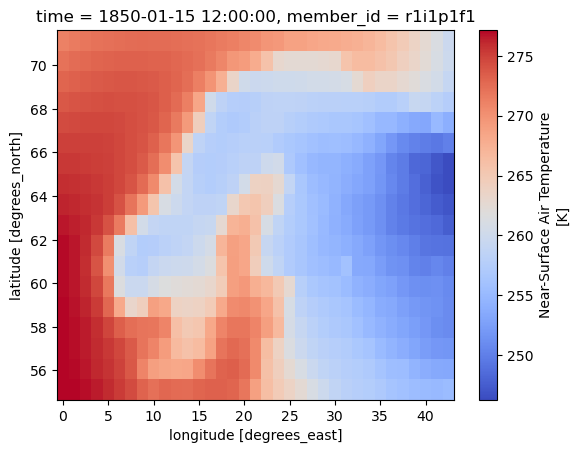

In [27]:
tas_AOI.isel(time=0).plot(cmap="coolwarm")

In the next episode, we will learn more about advanced visualization tools and how to make interactive plots using [holoviews](https://holoviews.org/), a tool part of the [HoloViz](https://holoviz.org/) ecosystem.

## Basic maths

Near-surface temperature values are in Kelvin and we can easily convert them in degrees celcius.

Simple arithmetic operations can be performed without worrying about dimensions and coordinates, using the same notation we use with `numpy`. Underneath xarray will automatically vectorize the operations over all the data dimensions.

In [28]:
tas_AOI - 273.15

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 18, lon: 35)>
array([[[[  3.9915466 ,   3.9372864 ,   3.63208   , ..., -17.947784  ,
          -18.09903   , -17.901337  ],
         [  3.9906616 ,   3.8585205 ,   3.4658813 , ..., -19.287094  ,
          -19.638443  , -19.815659  ],
         [  3.8772888 ,   3.693756  ,   3.3085938 , ..., -20.736603  ,
          -21.195053  , -21.357864  ],
         ...,
         [ -0.11868286,   0.1071167 ,   0.3340149 , ..., -11.844849  ,
          -12.702545  , -14.013733  ],
         [ -0.9946594 ,  -0.6482544 ,  -0.4326172 , ..., -10.813141  ,
          -12.086548  , -13.261871  ],
         [ -1.9762573 ,  -1.6532898 ,  -1.2767944 , ..., -10.560425  ,
          -11.828857  , -13.411926  ]],

        [[  6.5706787 ,   6.261444  ,   5.76593   , ..., -10.512054  ,
          -10.819702  , -11.010132  ],
         [  6.6134033 ,   6.326996  ,   5.8705444 , ..., -10.703583  ,
          -10.812073  , -11.228058  ],
         [  6.63974   ,   6.3713074 ,   5.99823   , ..., -10.811035  ,
          -11.002502  , -11.324585  ],
...
         [  4.5212708 ,   4.881195  ,   5.349457  , ...,  -0.38009644,
           -0.14691162,  -0.15356445],
         [  3.3636475 ,   3.8493652 ,   4.25      , ...,   0.430542  ,
            0.32699585,   0.23458862],
         [  2.291626  ,   2.7035522 ,   3.230133  , ...,   0.6605835 ,
            0.5307617 ,   0.37503052]],

        [[  9.923706  ,  10.213959  ,  10.246948  , ...,  -2.7084656 ,
           -3.117157  ,  -3.460785  ],
         [ 10.048218  ,  10.249817  ,  10.259094  , ...,  -2.855835  ,
           -3.1342468 ,  -3.5550232 ],
         [  9.972595  ,  10.138733  ,  10.1493225 , ...,  -3.176941  ,
           -3.5891113 ,  -3.8943787 ],
         ...,
         [  2.2316895 ,   2.5167236 ,   2.8789368 , ...,  -1.0142822 ,
           -1.0447388 ,  -1.3068542 ],
         [  0.93966675,   1.3753662 ,   1.7021484 , ...,  -0.4562683 ,
           -0.82281494,  -1.1673279 ],
         [ -0.25891113,   0.1281128 ,   0.6257019 , ...,  -0.47140503,
           -0.86395264,  -1.2958069 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'

The universal function ([ufunc](https://numpy.org/doc/stable/reference/ufuncs.html)) from numpy and scipy can be applied too directly to the data. There are currently more than 60 universal functions defined in numpy on one or more types, covering a wide variety of operations including math operations, trigonometric functions, etc.

In [29]:
np.subtract(tas_AOI, 273.15)

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 18, lon: 35)>
array([[[[  3.9915466 ,   3.9372864 ,   3.63208   , ..., -17.947784  ,
          -18.09903   , -17.901337  ],
         [  3.9906616 ,   3.8585205 ,   3.4658813 , ..., -19.287094  ,
          -19.638443  , -19.815659  ],
         [  3.8772888 ,   3.693756  ,   3.3085938 , ..., -20.736603  ,
          -21.195053  , -21.357864  ],
         ...,
         [ -0.11868286,   0.1071167 ,   0.3340149 , ..., -11.844849  ,
          -12.702545  , -14.013733  ],
         [ -0.9946594 ,  -0.6482544 ,  -0.4326172 , ..., -10.813141  ,
          -12.086548  , -13.261871  ],
         [ -1.9762573 ,  -1.6532898 ,  -1.2767944 , ..., -10.560425  ,
          -11.828857  , -13.411926  ]],

        [[  6.5706787 ,   6.261444  ,   5.76593   , ..., -10.512054  ,
          -10.819702  , -11.010132  ],
         [  6.6134033 ,   6.326996  ,   5.8705444 , ..., -10.703583  ,
          -10.812073  , -11.228058  ],
         [  6.63974   ,   6.3713074 ,   5.99823   , ..., -10.811035  ,
          -11.002502  , -11.324585  ],
...
         [  4.5212708 ,   4.881195  ,   5.349457  , ...,  -0.38009644,
           -0.14691162,  -0.15356445],
         [  3.3636475 ,   3.8493652 ,   4.25      , ...,   0.430542  ,
            0.32699585,   0.23458862],
         [  2.291626  ,   2.7035522 ,   3.230133  , ...,   0.6605835 ,
            0.5307617 ,   0.37503052]],

        [[  9.923706  ,  10.213959  ,  10.246948  , ...,  -2.7084656 ,
           -3.117157  ,  -3.460785  ],
         [ 10.048218  ,  10.249817  ,  10.259094  , ...,  -2.855835  ,
           -3.1342468 ,  -3.5550232 ],
         [  9.972595  ,  10.138733  ,  10.1493225 , ...,  -3.176941  ,
           -3.5891113 ,  -3.8943787 ],
         ...,
         [  2.2316895 ,   2.5167236 ,   2.8789368 , ...,  -1.0142822 ,
           -1.0447388 ,  -1.3068542 ],
         [  0.93966675,   1.3753662 ,   1.7021484 , ...,  -0.4562683 ,
           -0.82281494,  -1.1673279 ],
         [ -0.25891113,   0.1281128 ,   0.6257019 , ...,  -0.47140503,
           -0.86395264,  -1.2958069 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

In [30]:
tas_AOI = tas_AOI - 273.15

In [31]:
tas_AOI

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 18, lon: 35)>
array([[[[  3.9915466 ,   3.9372864 ,   3.63208   , ..., -17.947784  ,
          -18.09903   , -17.901337  ],
         [  3.9906616 ,   3.8585205 ,   3.4658813 , ..., -19.287094  ,
          -19.638443  , -19.815659  ],
         [  3.8772888 ,   3.693756  ,   3.3085938 , ..., -20.736603  ,
          -21.195053  , -21.357864  ],
         ...,
         [ -0.11868286,   0.1071167 ,   0.3340149 , ..., -11.844849  ,
          -12.702545  , -14.013733  ],
         [ -0.9946594 ,  -0.6482544 ,  -0.4326172 , ..., -10.813141  ,
          -12.086548  , -13.261871  ],
         [ -1.9762573 ,  -1.6532898 ,  -1.2767944 , ..., -10.560425  ,
          -11.828857  , -13.411926  ]],

        [[  6.5706787 ,   6.261444  ,   5.76593   , ..., -10.512054  ,
          -10.819702  , -11.010132  ],
         [  6.6134033 ,   6.326996  ,   5.8705444 , ..., -10.703583  ,
          -10.812073  , -11.228058  ],
         [  6.63974   ,   6.3713074 ,   5.99823   , ..., -10.811035  ,
          -11.002502  , -11.324585  ],
...
         [  4.5212708 ,   4.881195  ,   5.349457  , ...,  -0.38009644,
           -0.14691162,  -0.15356445],
         [  3.3636475 ,   3.8493652 ,   4.25      , ...,   0.430542  ,
            0.32699585,   0.23458862],
         [  2.291626  ,   2.7035522 ,   3.230133  , ...,   0.6605835 ,
            0.5307617 ,   0.37503052]],

        [[  9.923706  ,  10.213959  ,  10.246948  , ...,  -2.7084656 ,
           -3.117157  ,  -3.460785  ],
         [ 10.048218  ,  10.249817  ,  10.259094  , ...,  -2.855835  ,
           -3.1342468 ,  -3.5550232 ],
         [  9.972595  ,  10.138733  ,  10.1493225 , ...,  -3.176941  ,
           -3.5891113 ,  -3.8943787 ],
         ...,
         [  2.2316895 ,   2.5167236 ,   2.8789368 , ...,  -1.0142822 ,
           -1.0447388 ,  -1.3068542 ],
         [  0.93966675,   1.3753662 ,   1.7021484 , ...,  -0.4562683 ,
           -0.82281494,  -1.1673279 ],
         [ -0.25891113,   0.1281128 ,   0.6257019 , ...,  -0.47140503,
           -0.86395264,  -1.2958069 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 'r1i1p1f1'

## Statistics

All the standard statistical operations can be used such as `min`, `max`, `mean`. When no argument is passed to the function, the operation is done over all the dimensions of the variable (same as with `numpy`).

In [32]:
tas_AOI.min()

<xarray.DataArray 'tas' ()>
array(-26.84191895)

You can make a statistical operation over a dimension. For instance, let's retrieve the maximum tas value among all those available for different times, at each lat-lon location.

In [33]:
tas_AOI.max(dim='time')

<xarray.DataArray 'tas' (member_id: 1, lat: 18, lon: 35)>
array([[[17.913177 , 18.16388  , 18.275024 , 18.313934 , 18.328522 ,
         18.410065 , 18.476685 , 19.338104 , 20.345673 , 19.73639  ,
         19.681091 , 20.134735 , 19.119598 , 19.005066 , 19.041931 ,
         19.106995 , 19.019653 , 22.693756 , 24.226562 , 24.650146 ,
         24.417786 , 23.973938 , 23.803497 , 22.828125 , 22.704803 ,
         22.352753 , 22.175903 , 22.134857 , 23.450043 , 24.378357 ,
         25.166748 , 25.610962 , 24.972687 , 25.00238  , 24.528198 ],
        [17.241577 , 17.338257 , 17.492157 , 17.585663 , 17.65509  ,
         17.713348 , 17.98352  , 20.150513 , 21.748383 , 21.886383 ,
         21.556824 , 20.893677 , 20.363037 , 18.943329 , 18.613983 ,
         18.611572 , 18.620941 , 19.760834 , 23.221924 , 23.647827 ,
         23.514404 , 23.093231 , 23.336456 , 22.503937 , 22.339935 ,
         22.338959 , 22.166626 , 22.34134  , 23.142212 , 23.4458   ,
         24.20691  , 24.140076 , 24.62323  , 24.352112 , 24.227814 ],
        [16.807587 , 16.770233 , 16.859833 , 16.93045  , 16.981567 ,
         17.039246 , 17.455383 , 18.455078 , 19.253387 , 20.740967 ,
         21.366882 , 21.06958  , 20.757294 , 20.318634 , 18.286224 ,
         18.358154 , 18.349121 , 19.311615 , 21.430908 , 22.219482 ,
         22.33014  , 22.559174 , 22.694366 , 22.51947  , 22.080627 ,
         22.51355  , 22.614471 , 22.480713 , 22.66214  , 23.090118 ,
...
         12.900909 , 13.222961 , 13.52597  , 14.403259 , 15.553009 ,
         16.8042   , 16.932892 , 16.954376 , 17.034729 , 16.96762  ,
         16.96637  , 17.100616 , 17.330872 , 17.345306 , 17.114044 ,
         16.488129 , 14.975281 , 12.001068 , 13.143677 , 10.707916 ,
          9.694275 ,  9.177216 ,  9.027313 ,  8.803345 ,  8.669434 ],
        [ 9.139069 ,  9.590576 ,  9.904144 , 10.247589 , 10.48056  ,
         10.866425 , 11.181763 , 11.512421 , 11.786804 , 12.199493 ,
         12.608215 , 12.951721 , 13.20874  , 13.357086 , 13.322723 ,
         14.709045 , 13.948395 , 15.049042 , 16.412964 , 17.884033 ,
         17.783173 , 17.81784  , 17.365814 , 17.036255 , 16.102875 ,
         12.359375 ,  9.921783 ,  9.611908 ,  9.409424 ,  9.122467 ,
          8.811737 ,  8.50293  ,  8.18045  ,  7.9012146,  7.5783386],
        [ 8.040253 ,  8.353821 ,  8.763489 ,  9.011475 ,  9.314575 ,
          9.718872 , 10.178741 , 10.651154 , 11.184814 , 11.681763 ,
         12.085083 , 12.411102 , 12.637634 , 12.749329 , 12.723297 ,
         12.770172 , 12.895966 , 12.92099  , 12.873657 , 13.131958 ,
         14.395782 , 12.900848 , 12.762329 , 11.248535 , 10.335876 ,
          9.764557 ,  9.28595  ,  8.989227 ,  8.640686 ,  8.288513 ,
          7.905426 ,  7.5679626,  7.2664795,  7.0660706,  6.9654236]]],
      dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * member_id  (member_id) object 'r1i1p1f1'

## Aggregation
We have monthly data. To obtain yearly values, we can group values per year and compute the mean.

In [34]:
tas_yearly = tas_AOI.groupby(tas_AOI.time.dt.year).mean()

In [35]:
tas_yearly

<xarray.DataArray 'tas' (member_id: 1, year: 165, lat: 18, lon: 35)>
array([[[[10.190738  , 10.236267  , 10.129463  , ...,  4.487551  ,
           4.577349  ,  4.4684777 ],
         [10.055203  , 10.016124  ,  9.869583  , ...,  3.5996563 ,
           3.602525  ,  3.5518277 ],
         [ 9.951228  ,  9.84331   ,  9.695267  , ...,  2.8245113 ,
           2.760255  ,  2.7445972 ],
         ...,
         [ 2.131218  ,  2.480194  ,  2.8605297 , ..., -4.5990014 ,
          -4.9325995 , -5.297928  ],
         [ 0.8806508 ,  1.3956375 ,  1.7613932 , ..., -4.671717  ,
          -5.130834  , -5.525271  ],
         [-0.27815247,  0.1952184 ,  0.7522685 , ..., -4.968567  ,
          -5.4446716 , -5.893354  ]],

        [[10.707288  , 10.862836  , 10.859578  , ...,  7.673986  ,
           7.586838  ,  7.378306  ],
         [10.575684  , 10.646342  , 10.60096   , ...,  7.274389  ,
           7.101011  ,  6.786873  ],
         [10.451709  , 10.4361925 , 10.362701  , ...,  6.5675125 ,
           6.483808  ,  6.3353195 ],
...
         [ 3.899109  ,  4.278895  ,  4.683767  , ...,  0.22347514,
           0.07540639, -0.13505554],
         [ 2.6409404 ,  3.1836903 ,  3.5581539 , ...,  0.25100455,
          -0.05962372, -0.3530426 ],
         [ 1.38296   ,  1.857727  ,  2.4163895 , ...,  0.07100169,
          -0.25650534, -0.61615247]],

        [[11.859332  , 12.051389  , 12.075607  , ...,  8.140752  ,
           8.121837  ,  7.935308  ],
         [11.677655  , 11.791171  , 11.787402  , ...,  7.7124076 ,
           7.5722404 ,  7.4204307 ],
         [11.52195   , 11.550827  , 11.534116  , ...,  7.284935  ,
           7.149447  ,  7.030052  ],
         ...,
         [ 4.1399918 ,  4.518181  ,  4.9494348 , ...,  1.4126383 ,
           1.2889252 ,  1.1015829 ],
         [ 2.8445637 ,  3.3857346 ,  3.787501  , ...,  1.4600092 ,
           1.1696981 ,  0.8996175 ],
         [ 1.5644354 ,  2.0351918 ,  2.6172917 , ...,  1.269165  ,
           0.9806595 ,  0.6546936 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 55.13 56.07 57.02 57.96 ... 68.32 69.27 70.21 71.15
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 38.75 40.0 41.25 42.5
  * member_id  (member_id) object 'r1i1p1f1'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014

As we have data from 1850 to 2014, the time dimension is now `year` and takes values from `1850` to `2014`.

In [36]:
tas_yearly.year

<xarray.DataArray 'year' (year: 165)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873,
       1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897,
       1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

## Mask

Masking can be achieved through the method `DataSet|Array.where(cond, other)` or `xr.where(cond, x, y)`.

The difference consists in the possibility to specify the value in case the condition is positive or not; `DataSet|Array.where(cond, other)` only offer the possibility to define the false condition value (by default is set to np.NaN))

In [37]:
tas_masked = tas_AOI.where((tas_AOI >= -5.5) & (tas_AOI <= 15))

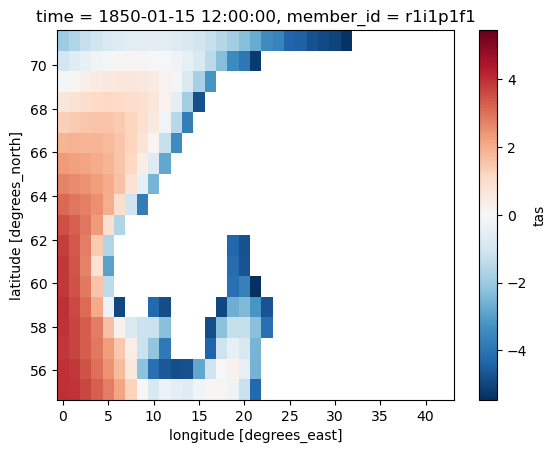

In [38]:
tas_masked.isel(time=0).plot()

To better visualize the mask, with the help of `xr.where`, ad-hoc variables can be created. 'xr.where' lets us specify values of 1 for masked and 0 for the unmasked data.

In [39]:
mask = xr.where((tas_AOI <= -5.5) | (tas_AOI >= 15), 1, 0)

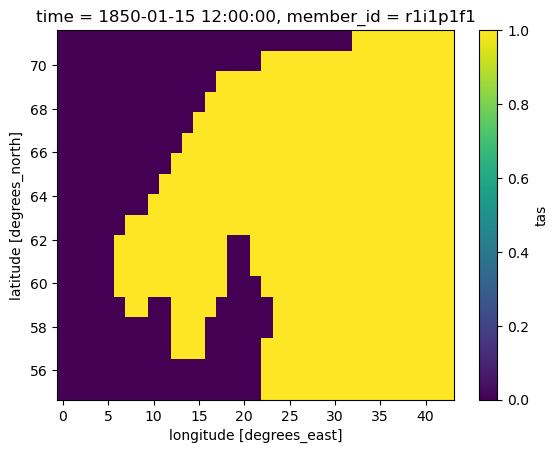

In [40]:
mask.isel(time=0).plot()

Plot a single point (defined by its latitude and longitude) over the time dimension.

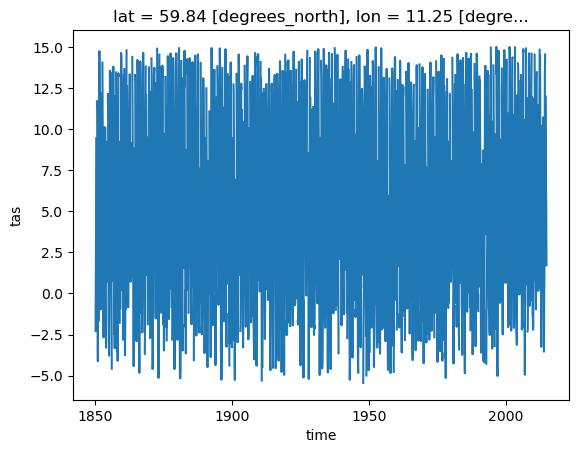

In [41]:
tas_masked.sel(lat=60., lon=10.75, method='nearest').plot()

## Save xarray Dataset

It is very often convenient to save intermediate or final results into a local file. We will learn more about the different file formats Xarray can handle, but for now let's save it as a netCDF file. Check the file size after saving the result into netCDF.

In [42]:
tas_masked.to_netcdf('tas_Nordic_masked.nc')

## Advanced Saving methods
### Encoding and Compression

From the near-surface temperature dataset we already know that values are encoded as `float32`. A compression method can be defined as well; if the format is netCDF4 with the engine set to 'netcdf4' or 'h5netcdf' there are different compression options.  The easiest solution is to stick with the default one for NetCDF4 files.

Note that encoding parameters needs to be done through a nested dictionary and parameters has to be defined for each single variable.

In [43]:
tas_masked.to_netcdf('tas_Nordic_mcs.nc',
                      engine='netcdf4',
                      encoding={'tas':{"dtype": np.float32,
                                        'zlib': True, 'complevel':4}
                                }
                      )

<div class=\"alert alert-success\">
<i class=\"fa-check-circle fa\" style=\"font-size: 22px;color:#666;\"></i> <b>Key Points</b>
<br>
<ul>
   <li>Xarray Dataset and DataArray</li>
   <li>Read and get metadata from local raster file</li>
   <li>Dataset and DataArray selection</li>
   <li>Aggregation and statistics</li>
   <li>Masking values</li>
   </ul>
</div>

Through the datatype and the compression a compression of almost 10 time has been achieved; as drawback speed reading has been decreased.

## References

```{bibliography}
:style: alpha
:filter: topic % "xarray" and not topic % "package"
:keyprefix: a-
```

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "xarray" and topic % "package"
:keyprefix: a-
```